<a href="https://colab.research.google.com/github/rgera2/Deep-Learning/blob/main/Q1_CNN_and_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2



*   Babandeep Singh
*   Robin Beura
*   Rahul Gera
*   Sanghmitra
*   Yash Patel




In [ ]:
import os 
from google.colab import drive
drive.mount("/content/drive")
os.chdir('/content/drive/Shared drives/IDS 576/Assignment 2/baban')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

from __future__ import print_function, division
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, datasets, transforms
from torch.autograd import Variable
import torchsummary
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

plt.ion()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Data Loading

In [ ]:
# Source:https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb
# add transforms to the data
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomRotation(45),
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(256),#attention
        transforms.CenterCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                            [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
trainset = {x: datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transforms[x])
            for x in ['train','val']}

dataloaders = {x: torch.utils.data.DataLoader(trainset[x],batch_size=4,
                                          shuffle=True, num_workers=4)
              for x in ['train','val']}

dataset_sizes = {x: len(trainset[x]) for x in ['train','val']}

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transforms['test'])

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=4)
dataset_sizes = {x: len(trainset[x]) for x in ['train', 'val']}
class_names = trainset['train'].classes

Using downloaded and verified file: ./data/cifar-10-python.tar.gz
Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


#Data Description and Plots

##Helper Functions

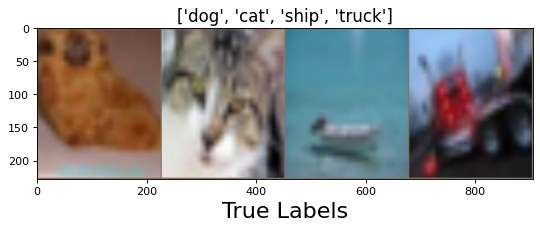

In [ ]:
def imshow(inp, ax=None,title=None,xlab=None,size=(8,2.5)):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    #fig, ax = plt.subplots(figsize=size)
    plt.figure(num=None, figsize=size, dpi=80,edgecolor='k')
    plt.imshow(inp,aspect='auto')
    plt.xlabel(xlab,fontsize=20)
    if title is not None:
      plt.title(title,size=15)
    plt.pause(0.001)  # pause a bit so that plots are updated
    #plt.title(title)
    #plt.show()

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes],xlab='True Labels')

###Training Function

In [ ]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=15):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            #if phase == 'train':
            #    scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Plotting Predictions

In [ ]:
def visualize_model(model,boolean,cls):
  counter = 0
  wrong_inputs,correct_class,predicted_class = [],[],[]
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  with torch.no_grad():

    for i, (inputs, labels) in enumerate(testloader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      c = (preds == labels).squeeze()
      
      for i in range(4):
        if c[i]==boolean and labels.data[i]==cls:
          counter+=1
          wrong_inputs.append(inputs.cpu().data[i])
          correct_class.append(class_names[labels[i]])
          predicted_class.append(class_names[preds[i]])
    #imshow(inputs.cpu().data[i],
    #title='Correct Class:{} | Predicted Class:{}'.format(class_names[labels[i]],class_names[preds[i]]))
      if counter==5:
            #wrong_inputs,correct_class,predicted_class = [],[],[]
        break
  out = torchvision.utils.make_grid(wrong_inputs)
  if boolean==True:
    imshow(out, 
           title=predicted_class,
           xlab='Correct Predictions of {} | Test Accuracy: {}'.format(correct_class[0],test_acc[cls]))
  else:
    imshow(out,
           title=predicted_class,
           xlab='Incorrect Predictions of {} | Test Accuracy: {}'.format(correct_class[0],test_acc[cls]))

### Function:Accuracy by Class

In [ ]:
def div(a,b):
  return a/b

def acc(dataLoader,model_conv):
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  with torch.no_grad():
    for data in testloader:
      images, labels = data
      outputs = model_conv(images.to(device))
      _, predicted = torch.max(outputs, 1)
      c = (predicted == labels.to(device)).squeeze()
      for i in range(4):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
  for i in range(10):
    print('Testing Accuracy of %5s : %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))
  print('Average Testing Accuracy after Fine Tuning:%2d %%' % (np.mean(list(map(div, class_correct,class_total)))*100))

def test_accuracy(dataLoader,model_conv):
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  with torch.no_grad():
    for data in testloader:
      images, labels = data
      outputs = model_conv(images.to(device))
      _, predicted = torch.max(outputs, 1)
      c = (predicted == labels.to(device)).squeeze()
      for i in range(4):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
  #for i in range(10):
    #print('Testing Accuracy of %5s : %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))
  return list(map(div, class_correct,class_total))*100

#Feature Extraction

In [ ]:
lr = 0.001 #learning rate
weight_decay = 0.0 # l2 regularizer

model_FE = torchvision.models.resnet18(pretrained=True)
for param in model_FE.parameters():
    param.requires_grad = False

import torch.nn as nn
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_FE.fc.in_features
model_FE.fc = nn.Linear(num_ftrs, 10)

model_FE = model_FE.to(device)

criterion = nn.CrossEntropyLoss()
#Optimizing final layer only
optimizer_FE = optim.SGD(model_FE.fc.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


##Model Training

In [ ]:
model = train_model(model_FE, criterion, optimizer_FE,num_epochs=20)

Epoch 0/19
----------
train Loss: 1.2172 Acc: 0.6051
val Loss: 0.7494 Acc: 0.7560

Epoch 1/19
----------
train Loss: 1.1982 Acc: 0.6150
val Loss: 0.7833 Acc: 0.7427

Epoch 2/19
----------
train Loss: 1.1969 Acc: 0.6183
val Loss: 0.7531 Acc: 0.7544

Epoch 3/19
----------
train Loss: 1.1930 Acc: 0.6182
val Loss: 0.8408 Acc: 0.7365

Epoch 4/19
----------
train Loss: 1.1855 Acc: 0.6217
val Loss: 0.7568 Acc: 0.7527

Epoch 5/19
----------
train Loss: 1.1960 Acc: 0.6196
val Loss: 0.8514 Acc: 0.7310

Epoch 6/19
----------
train Loss: 1.2005 Acc: 0.6189
val Loss: 0.7049 Acc: 0.7660

Epoch 7/19
----------
train Loss: 1.1914 Acc: 0.6220
val Loss: 0.8477 Acc: 0.7331

Epoch 8/19
----------
train Loss: 1.1955 Acc: 0.6214
val Loss: 0.7435 Acc: 0.7582

Epoch 9/19
----------
train Loss: 1.1964 Acc: 0.6197
val Loss: 0.7949 Acc: 0.7447

Epoch 10/19
----------
train Loss: 1.1808 Acc: 0.6241
val Loss: 0.7692 Acc: 0.7524

Epoch 11/19
----------
train Loss: 1.2034 Acc: 0.6195
val Loss: 0.7971 Acc: 0.7429

Ep

In [ ]:
# saving the model 
torch.save(model.state_dict(), "classifier_930.pt")

##Perfromance of model on Test data

In [ ]:
#loading Model
model_FE.load_state_dict(torch.load("Feature Extracted Linear Classifier.pt"))
model_FE.eval()

In [ ]:
acc(testloader,model_FE)

Testing Accuracy of airplane : 78 %
Testing Accuracy of automobile : 86 %
Testing Accuracy of  bird : 74 %
Testing Accuracy of   cat : 59 %
Testing Accuracy of  deer : 64 %
Testing Accuracy of   dog : 70 %
Testing Accuracy of  frog : 83 %
Testing Accuracy of horse : 79 %
Testing Accuracy of  ship : 85 %
Testing Accuracy of truck : 76 %
Average Testing Accuracy after Feature Extraction :75 %


**(a) Describe any choices made and report test performance.**

> We have considered CrossEntropy loss, as this is a multiclass classification. Additionally, we have not added regularizer here, weight_decay = 0, and added momentum parameter in the SGD optimizer by the virtue of capabilities which helps accelerate gradients vectors in the right directions, thus leading to faster converging Ning et. al.[1]

> After training for 20 epochs, we are able to get 76% validation and 75% test accuracy. 


**Reference:** 
Ning Qian. On the momentum term in gradient descent learning algorithms. Neural networks : the official journal of the International Neural Network Society, 12(1):145–151, 1999

**(b) Display the top 5 correct predictions and the top 5 incorrect predictions in each class (show the images and the prediction labels) compactly.**

##Correct Predictions

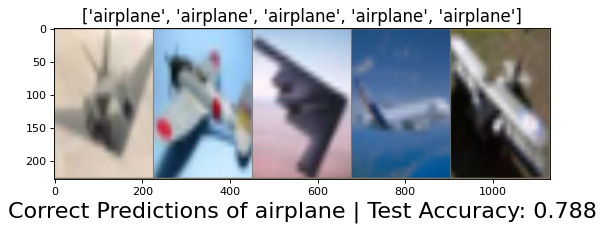

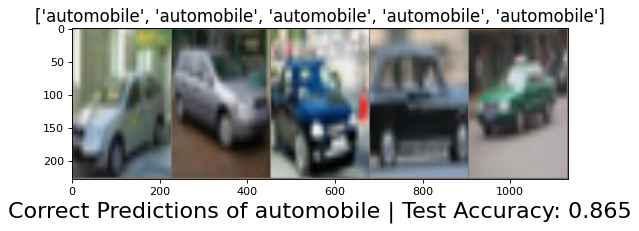

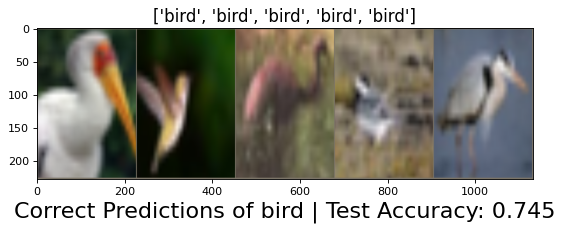

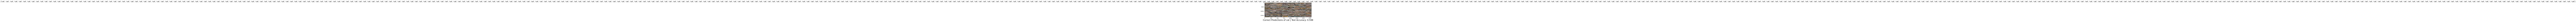

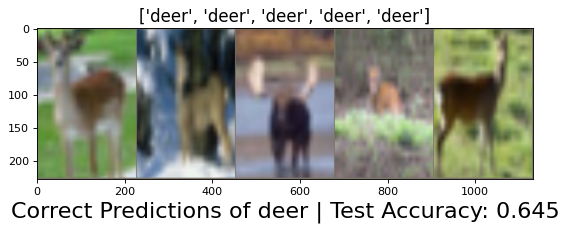

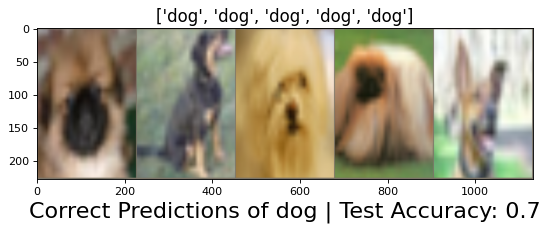

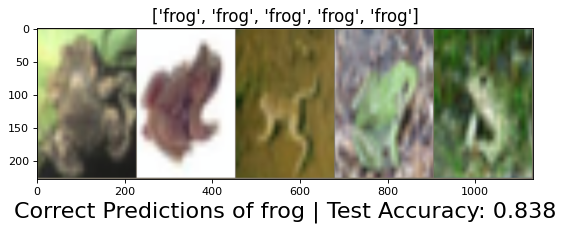

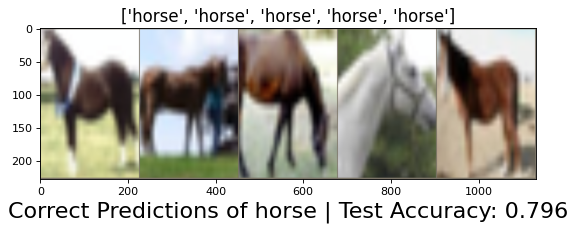

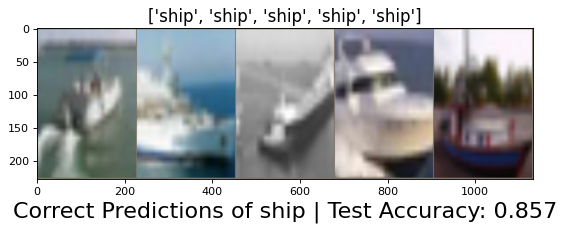

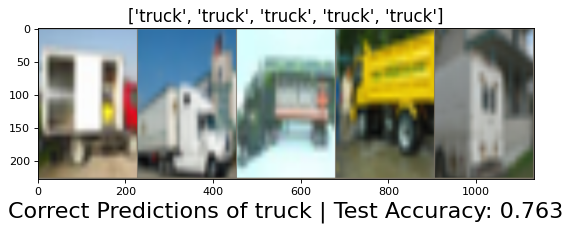

In [ ]:
test_acc = test_accuracy(testloader,model_FE)
for i in range(10):
  visualize_model(model_FE,True,i)

##Incorrect Predictions

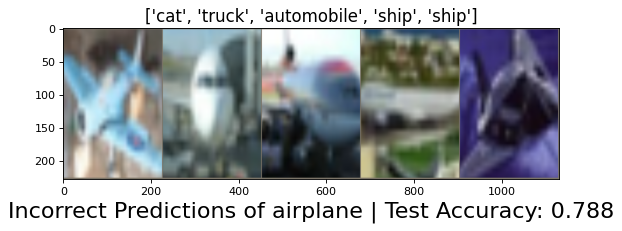

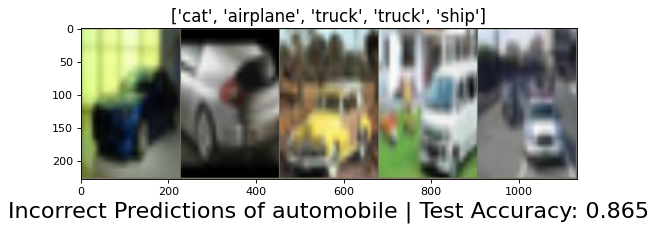

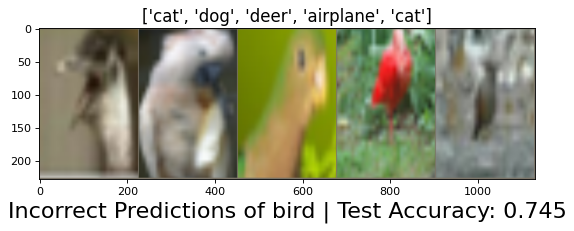

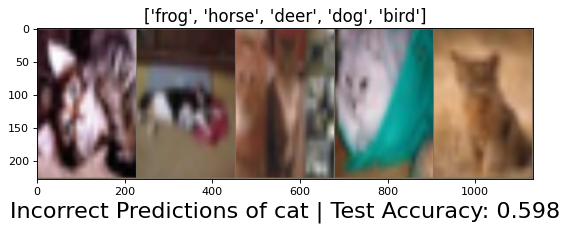

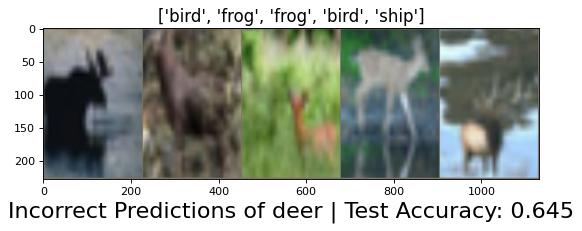

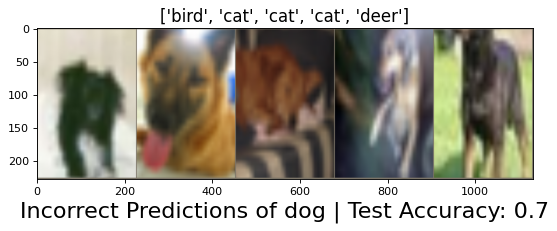

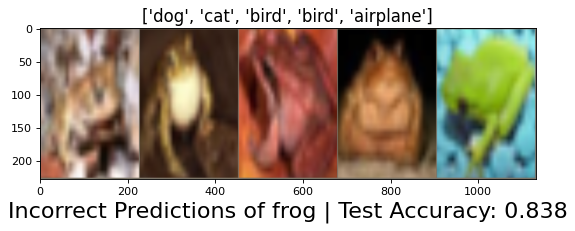

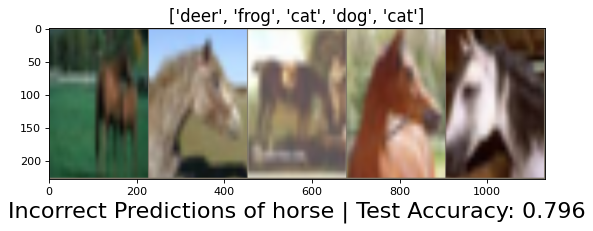

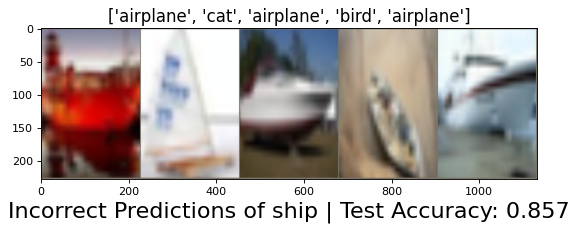

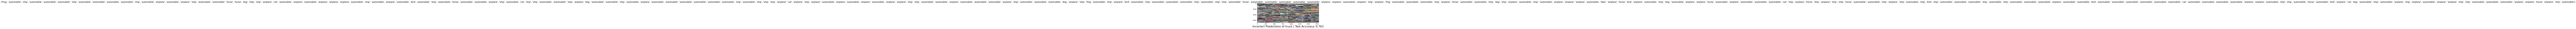

In [ ]:
for i in range(10):
  visualize_model(model_FE,False,i)
  plt.show()

#Fine Tuning

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# All parameters are being optimized

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

## Model Training


In [ ]:
model_fine_tuned = train_model(model_ft, criterion, optimizer_ft,num_epochs=20)

Epoch 0/19
----------
train Loss: 0.8161 Acc: 0.7394
val Loss: 0.2999 Acc: 0.8991

Epoch 1/19
----------
train Loss: 0.4664 Acc: 0.8516
val Loss: 0.1601 Acc: 0.9470

Epoch 2/19
----------
train Loss: 0.3301 Acc: 0.8944
val Loss: 0.1789 Acc: 0.9372

Epoch 3/19
----------
train Loss: 0.2515 Acc: 0.9204
val Loss: 0.1051 Acc: 0.9658

Epoch 4/19
----------
train Loss: 0.1883 Acc: 0.9394
val Loss: 0.0649 Acc: 0.9788

Epoch 5/19
----------
train Loss: 0.1482 Acc: 0.9519
val Loss: 0.0520 Acc: 0.9837

Epoch 6/19
----------
train Loss: 0.1112 Acc: 0.9647
val Loss: 0.0583 Acc: 0.9808

Epoch 7/19
----------
train Loss: 0.0896 Acc: 0.9717
val Loss: 0.0399 Acc: 0.9881

Epoch 8/19
----------
train Loss: 0.0764 Acc: 0.9765
val Loss: 0.0467 Acc: 0.9853

Epoch 9/19
----------
train Loss: 0.0611 Acc: 0.9821
val Loss: 0.0311 Acc: 0.9910

Epoch 10/19
----------
train Loss: 0.0570 Acc: 0.9835
val Loss: 0.0543 Acc: 0.9820

Epoch 11/19
----------
train Loss: 0.0439 Acc: 0.9875
val Loss: 0.0325 Acc: 0.9905

Ep

In [ ]:
# saving the model 
torch.save(model_fine_tuned.state_dict(), "Fine Tuned Resnet18.pt")

In [ ]:
#loading Model
model_ft.load_state_dict(torch.load("Fine Tuned Resnet18.pt"))
model_ft.eval()

## Perfromance of Model on Test Data

In [ ]:
acc(testloader,model_ft)

Testing Accuracy of airplane : 96 %
Testing Accuracy of automobile : 97 %
Testing Accuracy of  bird : 90 %
Testing Accuracy of   cat : 80 %
Testing Accuracy of  deer : 93 %
Testing Accuracy of   dog : 93 %
Testing Accuracy of  frog : 94 %
Testing Accuracy of horse : 95 %
Testing Accuracy of  ship : 95 %
Testing Accuracy of truck : 89 %
Average Testing Accuracy after Fine Tuning:92 %


## Correct Predictions

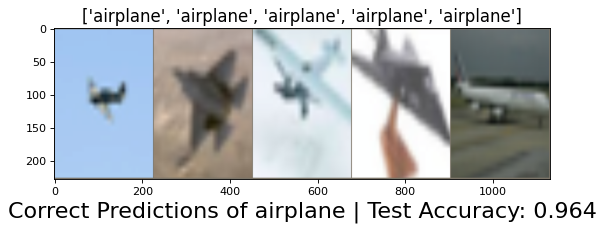

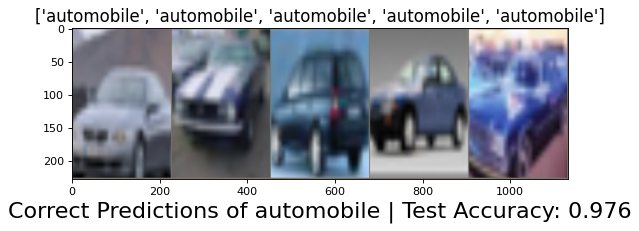

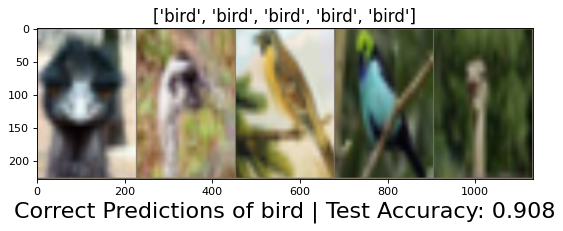

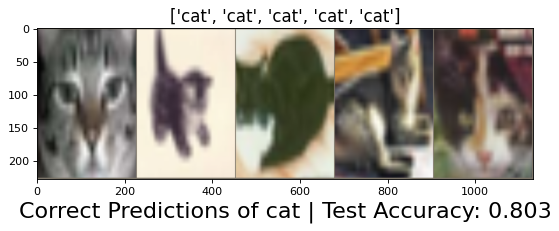

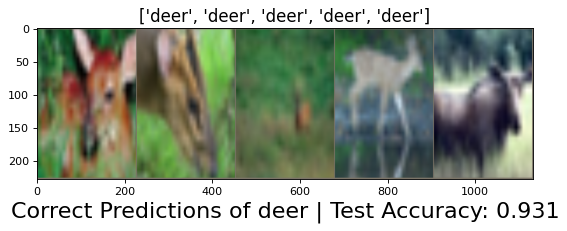

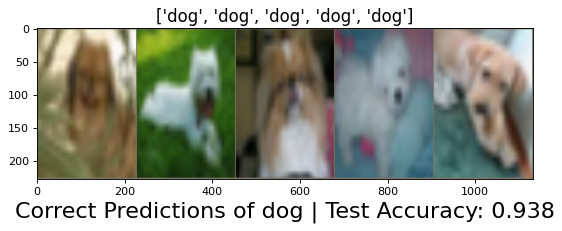

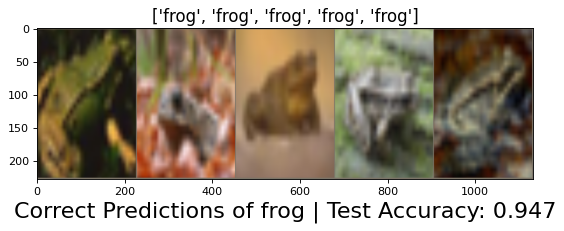

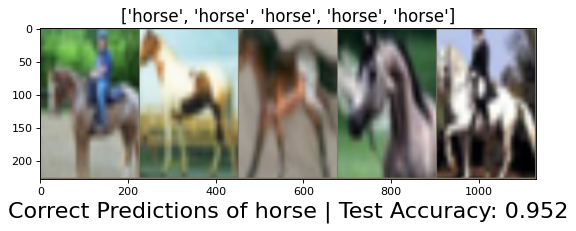

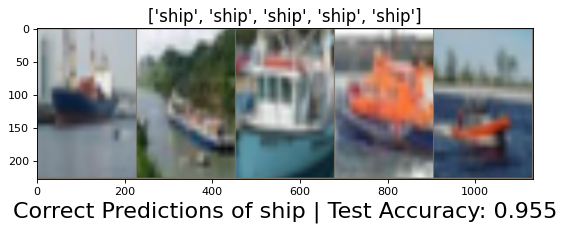

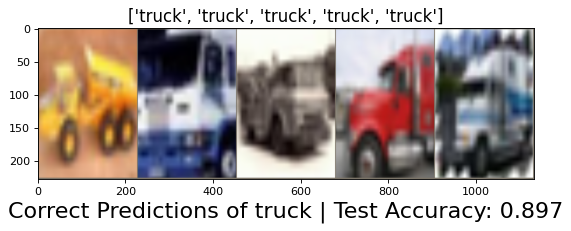

In [ ]:
test_acc = test_accuracy(testloader,model_ft)
for i in range(10):
  visualize_model(model_ft,True,i)

## Incorrect Predictions

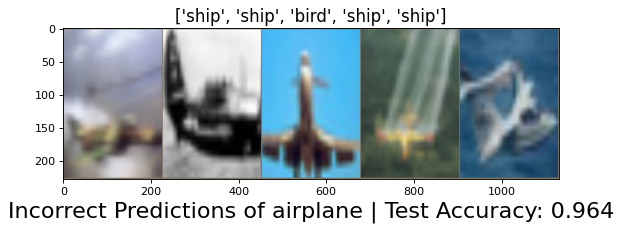

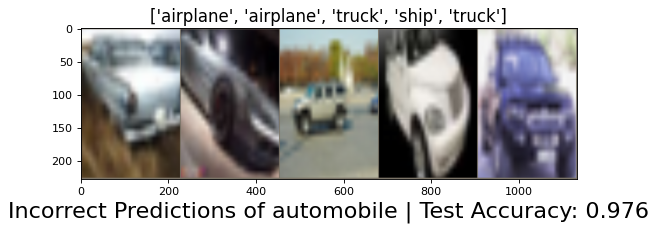

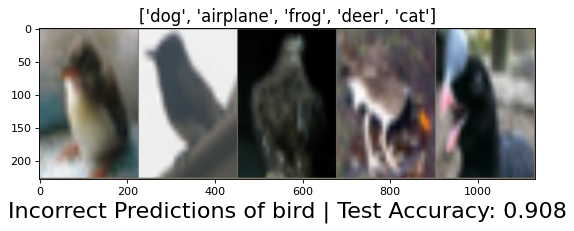

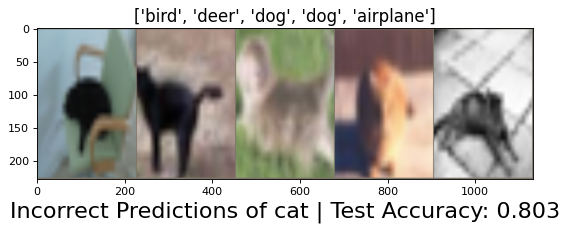

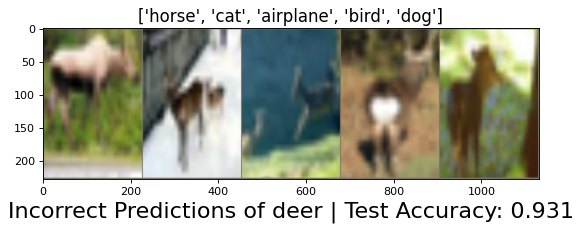

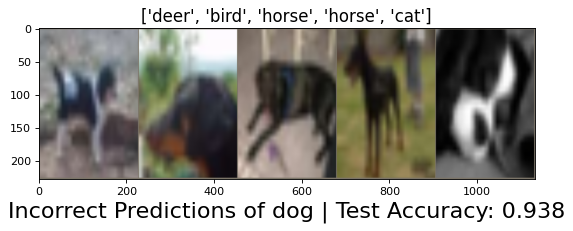

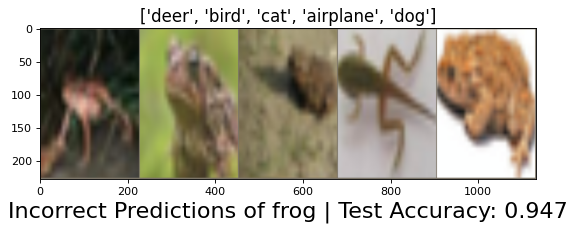

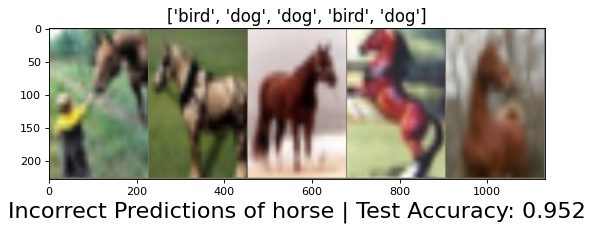

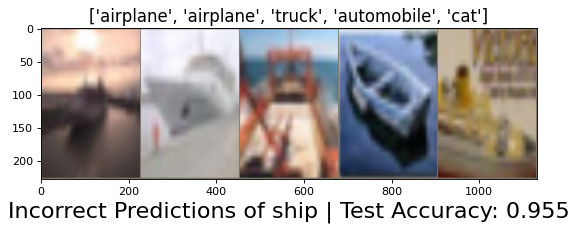

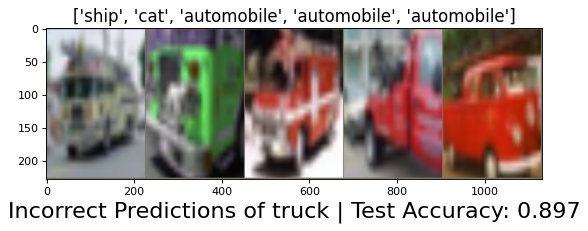

In [ ]:
for i in range(10):
  visualize_model(model_ft,False,i)
  plt.show()

**Finetuned the Resnet18 model’s parameters suitably and repeated parts (a) and (b) from above.**

**Compare the performance of finetuning versus using extracted features.**

> After making the weights trainable through out the architecture of the neural network, the validation accuracy is 99%  and test accuracy 93%. Which is much more higher than Multiclass Logistic Regression model that we defined earlier and trained using Extracted Features.

> Main reason behind for this upgrade in accuracy is this time we are training Resnet18 using the training data hence, model is able to learn more specific features about our unique data.

#References


*   Data Loading ->https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
*   Major Chunk ->https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


> data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

> labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

> Deciding on which layer to extract from is a bit of a science, but something to keep in mind is that early layers in the network are usually learning high-level features such as ‘image contains fur’ or ‘image contains round object’, while lower-level features are more specific to the training data. The ‘avgpool’ layer selected here is at the end of ResNet-18, but if you plan to use images that are very different from ImageNet, you may benefit in using an ealier layer or fine-tuning the model.

* https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0
* https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c
* https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd

**Deep residual networks pre-trained on ImageNet**

<img src="https://pytorch.org/assets/images/resnet.png" alt="alt" width="50%"/>
